In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def g_left_of_main(car, road_rules):
    return road_rules["x_min"] - car.state[0]

def g_right_of_main(car, road_rules):
    return car.state[0] - road_rules["x_max"]

def g_outside_rightband(car, road_rules):
    return max(
        car.state[1] - road_rules["y_max"],
        road_rules["y_min"] - car.state[1]
    )

In [3]:
# s: state of system
# x: x coordinate of car
# y: y coordinate of car
# theta: heading angle of car wrt world coordinate
# phi: steering angle
# v: velocity
# system has 2 cars
# s = [x1, y1, theta1, phi1, v1, x2, y2, theta2, phi2, v2]

In [4]:
"""
BSD 3-Clause License

Copyright (c) 2019, HJ Reachability Group
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

Author(s): David Fridovich-Keil ( dfk@eecs.berkeley.edu )
"""
################################################################################
#
# 5D car model. Dynamics are as follows, adapted from
# https://ac.els-cdn.com/S2405896316301215/1-s2.0-S2405896316301215-main.pdf?_tid=ad143a13-6571-4733-a984-1b5a41960e78&acdnat=1552430727_12aedd0da2ca11eb07eef49d27b5ab12
#                          \dot x     = v cos theta
#                          \dot y     = v sin theta
#                          \dot theta = v * tan(phi) / l
#                          \dot phi   = u1
#                          \dot v     = u2
#
################################################################################

import torch
import numpy as np

from dynamical_system import DynamicalSystem

class Car5Dv2(DynamicalSystem):
    """ 5D car model. """

    def __init__(self, T=0.1, **kwargs):
        self._l = kwargs["wheelbase"]
        self.length = kwargs["length"]
        self.width = kwargs["width"]
        self.R = math.sqrt((0.5 * (self.length - self._l)) ** 2 + (0.5 * self.width) ** 2) 
        
        self.state = np.zeros(5)
        
        super(Car5Dv2, self).__init__(5, 2, T)
        
    def get_poc(self):
        rear = np.array([self.state[0], self.state[1]]) # rear
        front = rear + self._l * np.array([math.cos(self.state[2]), math.sin(self.state[2])]) # front
        return rear, front

    def __call__(self, x, u):
        """
        Compute the time derivative of state for a particular state/control.
        NOTE: `x` and `u` should be 2D (i.e. column vectors).

        :param x: current state
        :type x: torch.Tensor or np.array
        :param u: current control input
        :type u: torch.Tensor or np.array
        :return: current time derivative of state
        :rtype: torch.Tensor or np.array
        """
        if isinstance(x, np.ndarray):
            assert isinstance(u, np.ndarray)
            x_dot = np.zeros((self._x_dim, 1))
            cos = np.cos
            sin = np.sin
            tan = np.tan
        else:
            assert isinstance(u, torch.Tensor)
            x_dot = torch.zeros((self._x_dim, 1))
            cos = torch.cos
            sin = torch.sin
            tan = torch.tan

        x_dot[0, 0] = x[4, 0] * cos(x[2, 0])
        x_dot[1, 0] = x[4, 0] * sin(x[2, 0])
        x_dot[2, 0] = x[4, 0] * tan(x[3, 0]) / self._l
        x_dot[3, 0] = u[0, 0]
        x_dot[4, 0] = u[1, 0]
        
        self.state = x
        
        return x_dot


In [5]:
# car params
# Delorean DMC
# https://en.wikipedia.org/wiki/DMC_DeLorean

car_params = {
    "wheelbase": 2.413, 
    "length": 4.267,
    "width": 1.988
}

car1 = Car5Dv2(T = 0.1, **car_params)
car2 = Car5Dv2(T = 0.1, **car_params)

def g_coll_ff(car1, car2):
    car1_rear, car1_front = car1.get_poc()
    car2_rear, car2_front = car2.get_poc()
    return 4 * car1.R**2 - (car1_front[0] - car2_front[0]) ** 2 - (car1_front[1] - car2_front[1]) ** 2

def g_coll_fr(car1, car2):
    car1_rear, car1_front = car1.get_poc()
    car2_rear, car2_front = car2.get_poc()
    return 4 * car1.R**2 - (car1_front[0] - car2_rear[0]) ** 2 - (car1_front[1] - car2_rear[1]) ** 2

def g_coll_rf(car1, car2):
    car1_rear, car1_front = car1.get_poc()
    car2_rear, car2_front = car2.get_poc()
    return 4 * car1.R**2 - (car1_rear[0] - car2_front[0]) ** 2 - (car1_rear[1] - car2_front[1]) ** 2

def g_coll_rr(car1, car2):
    car1_rear, car1_front = car1.get_poc()
    car2_rear, car2_front = car2.get_poc()
    return 4 * car1.R**2 - (car1_rear[0] - car2_rear[0]) ** 2 - (car1_rear[1] - car2_rear[1]) ** 2

In [6]:
# road rules for T-intersection
#----------------
#|  |        |
#|           |
#|  |        |
#|           |
#|  |        |_______________ y_max
#|
#|  |
#|
#|  |        ._______________ y_min
#|           |
#|  |        |
#|           |
#x_min    x_max

road_rules = {
    "x_min": 2,
    "x_max": 9,
    "y_max": 17,
    "y_min": 10,
    "width": 3.5,
}

def circle_intersection(car, x_circle, y_circle, r_circle):
    return r_circle**2 - (car.state[0] - x_circle) ** 2 - (car.state[1] - y_circle) ** 2

def g_road_rules(car, road_rules, left_lane = True, right_lane = True, up_lane = False, down_lane = True, left_turn = False):
    """
        Only use for T intersection that both cars can only either go straight or merge to the left of the map.
            * Cars that are on the right lane can turn right or go straight up
            * Cars that are on the left lane can turn left or go straight down
        Use the flags to bound the safety area:
            left_turn (bool): allow left turn, with safety arc at the corner
            left_lane (bool): allow running on left lane
            right_lane (bool): allow running on the right lane
            up_lane (bool): allow running on the up lane
            down_lane (bool): allow running on the down lane
    """
    import copy
    new_road_rules = copy.deepcopy(road_rules)
    if down_lane and not up_lane:
        new_road_rules["y_max"] = road_rules["y_max"] - road_rules["width"]
    elif up_lane and not down_lane:
        new_road_rules["y_min"] = road_rules["y_min"] + road_rules["width"]
    
    if left_lane and not right_lane:
        # Can either go straight down or turn left
        new_road_rules["x_max"] = road_rules["x_max"] - road_rules["width"]
    elif right_lane and not left_lane:
        # Can either go straight up or turn right
        new_road_rules["x_min"] = road_rules["x_min"] + road_rules["width"]
        
    if not left_turn:
        return max(
            g_left_of_main(car, new_road_rules), 
            min(
                g_right_of_main(car, new_road_rules), 
                g_outside_rightband(car, new_road_rules)
            )
        )
    else:
        x_circle = road_rules["x_max"]
        y_circle = road_rules["y_max"]
        r_circle = road_rules["width"]
        return max(
            g_road_rules(car, road_rules, left_lane = True, right_lane = False, up_lane = True, down_lane = True, left_turn = False),
            g_road_rules(car, road_rules, left_lane = True, right_lane = True, down_lane = True, up_lane = False, left_turn = False),
            circle_intersection(car, x_circle, y_circle, r_circle)
        )

def g_maneuver(car):
    pass

def g_collision(car1, car2):
    return max(
        g_coll_ff(car1, car2),
        g_coll_fr(car1, car2),
        g_coll_rf(car1, car2),
        g_coll_rr(car1, car2)
    )

# def g(car1, car2, road_rules):
#     return max(g_road_rules(car1, road_rules), g_maneuver(car1), g_collision(car1, car2))

In [7]:
# def circle_intersection(car, x_circle, y_circle, r_circle):
#     return r_circle**2 - (car.state[0] - x_circle) ** 2 - (car.state[1] - y_circle) ** 2

# def g_road_rules_left_turn(car, road_rules):
#     road_rules_offset_1 = {
#         "x_min": 2,
#         "x_max": 2 + 3.5,
#         "y_max": 17,
#         "y_min": 10,
#         "wdith": 3.5,
#         "left_turn": True
#     }
    
#     road_rules_offset_2 = {
#         "x_min": 2,
#         "x_max": 9,
#         "y_max": 10 + 3.5,
#         "y_min": 10,
#         "wdith": 3.5,
#         "left_turn": True
#     }
    
#     x_circle = 9
#     y_circle = 17
#     r_circle = road_rules["width"]
    
#     return max(
#         g_road_rules(car, road_rules_offset_1),
#         g_road_rules(car, road_rules_offset_2),
#         circle_intersection(car, x_circle, y_circle, r_circle)
#     )

In [8]:
def draw_roads(road_rules, x_max, y_max):
    """
        x_max: max value of plot in x axis
        y_max: max value of plot in y axis
    """
    print(road_rules)
    # This function draw t-intersection based on road_rules
    x_center = road_rules["x_min"] + 0.5 * (road_rules["x_max"] - road_rules["x_min"])
    y_center = road_rules["y_min"] + 0.5 * (road_rules["y_max"] - road_rules["y_min"])
    plt.plot([road_rules["x_min"], road_rules["x_min"]], [0, x_max], c='k')
    plt.plot([road_rules["x_max"], road_rules["x_max"]], [0, road_rules["y_min"]], c='k')
    plt.plot([road_rules["x_max"], road_rules["x_max"]], [road_rules["y_max"], x_max], c='k')
    plt.plot([road_rules["x_min"], road_rules["x_min"]], [road_rules["y_min"], road_rules["y_min"]], c='k')
    plt.plot([road_rules["x_max"], y_max], [road_rules["y_min"], road_rules["y_min"]], c='k')
    plt.plot([road_rules["x_min"], road_rules["x_min"]], [road_rules["y_max"], road_rules["y_max"]], c='k')
    plt.plot([road_rules["x_max"], y_max], [road_rules["y_max"], road_rules["y_max"]], c='k')
    plt.plot([x_center, x_center], [0, x_max], "--", c = 'b')
    plt.plot([road_rules["x_max"], y_max], [y_center, y_center], "--", c = 'b')

In [12]:
from matplotlib.transforms import Affine2D

# fig = plt.figure()
# plt.gca().set_aspect('equal')

# rear = np.array([2, 1])
# rotate_deg = 30
# length = 4.2
# width = 1.7
# wheelbase = 3
# a = 0.5 * (length - wheelbase)

# plt.plot(rear[0], rear[1], color='r', marker='o', markersize=10)
# rec = plt.Rectangle(rear+np.array([-a, -0.5*width]), width=length, height=width, color='g', alpha=0.9,
#                         transform=Affine2D().rotate_deg_around(*(rear[0], rear[1]), rotate_deg)+plt.gca().transData)
# plt.gca().add_patch(rec)
# plt.show()

def draw_car(cars):
    for car in cars:
        plt.gca().set_aspect('equal')
        rear, front = car.get_poc()
        rotate_deg = car.state[2]/np.pi * 180
        length = car.length
        width = car.width
        wheelbase = car._l
        a = 0.5 * (length - wheelbase)

        plt.plot(rear[0], rear[1], color='r', marker='o', markersize=10)
        rec = plt.Rectangle(rear-np.array([a, 0.5*width]), width=length, height=width, color = 'g', alpha=0.8,
                                transform=Affine2D().rotate_deg_around(*(rear[0], rear[1]), rotate_deg)+plt.gca().transData)
        plt.gca().add_patch(rec)
        
def safety_contour(road_rules, left_lane = False, right_lane = False, up_lane = False, down_lane = False, left_turn = False):
    x_range = np.arange(0, 20, step = 0.1)
    y_range = np.arange(0, 25, step = 0.1)
    car = Car5Dv2(T = 0.1, **car_params)
    zz = np.array([[0]*200]*250)
    for x in x_range:
        for y in y_range:
            car.state = np.array([x, y, 0, 0, 0])
            zz[int(y*10)][int(x*10)] = g_road_rules(car, road_rules, left_lane = left_lane, right_lane = right_lane, up_lane = up_lane, down_lane = down_lane, left_turn = left_turn)
    # contour = plt.contourf(x_range, y_range, zz, cmap = "YlGn", levels = np.arange(-10, 30))
    # plt.colorbar(contour)

    contour = plt.contourf(x_range, y_range, zz, cmap = "Purples", alpha = 0.3, levels = [-3, -2, -1, 0], extend = "both")
    plt.clabel(contour, inline=True, fontsize=10, colors="k")
    contour.cmap.set_under('white')
    contour.cmap.set_over('navy')

4.870891000000003
0.0 -2.0
{'x_min': 2, 'x_max': 9, 'y_max': 17, 'y_min': 10, 'width': 3.5}


/home/buzi/miniconda3/envs/reach-avoid-games/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Purples"))
/home/buzi/miniconda3/envs/reach-avoid-games/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Purples"))


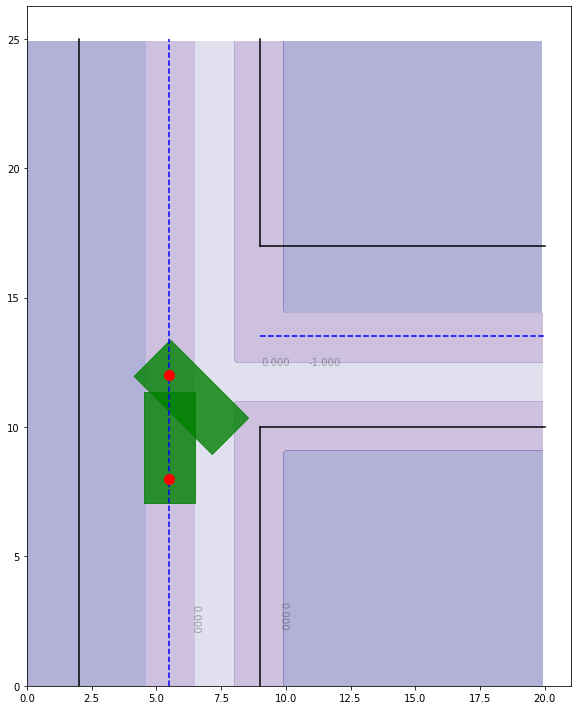

In [16]:
car1.state = np.array([5.5, 8, np.pi/2, 0, 0])
car2.state = np.array([5.5, 12, -np.pi/4, 0, 0])
print(g_collision(car1, car2))
print(
    g_road_rules(car1, road_rules, left_lane = False, right_lane = True, up_lane = False, down_lane = True, left_turn = False),
    g_road_rules(car2, road_rules, left_lane = True, right_lane = False, up_lane = False, down_lane = True, left_turn = True)
)

fig = plt.figure(figsize = (10, 12.5))
# draw the roads
draw_roads(road_rules, 25, 20)
draw_car([car1, car2])
safety_contour(road_rules, left_lane = False, right_lane = True, up_lane = False, down_lane = True, left_turn = False)
plt.show()

In [11]:
"""
BSD 3-Clause License

Copyright (c) 2019, HJ Reachability Group
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

Author(s): David Fridovich-Keil ( dfk@eecs.berkeley.edu )
"""
################################################################################
#
# Script to run a 3 player collision avoidance example intended to model
# a T-intersection.
#
################################################################################

import os
import numpy as np
import matplotlib.pyplot as plt

#from unicycle_4d import Unicycle4D
#from bicycle_4d import Bicycle4D
from car_5d import Car5D
from car_10d import Car10D
from product_multiplayer_dynamical_system import \
    ProductMultiPlayerDynamicalSystem
from point_mass_2d import PointMass2D

from point import Point
from polyline import Polyline

#from ilq_solver import ILQSolver
#from ilq_solver_reach_avoid_twoplayer_playaround import ILQSolver

#from ilq_solver_horizontal_twoplayer_timeconsistent import ILQSolver
from ilq_solver_twoplayer_cooperative_time_consistent_refactored import ILQSolver
#from ilq_solver_time_consistent import ILQSolver
from proximity_cost_reach_avoid_twoplayer import ProximityCost
#from product_state_proximity_cost import ProductStateProximityCost
from distance_twoplayer_cost import ProductStateProximityCost
from distance_twoplayer_cost_adversarial import ProductStateProximityCostAdversarial
from semiquadratic_cost import SemiquadraticCost
from quadratic_cost import QuadraticCost
#from semiquadratic_polyline_cost import SemiquadraticPolylineCost
from semiquadratic_polyline_cost_draw import SemiquadraticPolylineCostDraw
from quadratic_polyline_cost import QuadraticPolylineCost
#from player_cost import PlayerCost
#from player_cost_reach_avoid_twoplayer import PlayerCost
from player_cost_threeplayer_reachavoid_timeconsistent import PlayerCost
from nominal_velocity_deviation_cost import NominalVelocityDeviationCost

from visualizer import Visualizer
from logger import Logger

# General parameters.
TIME_HORIZON = 3.0    # s #Change back to 2.0
TIME_RESOLUTION = 0.1 # s
HORIZON_STEPS = int(TIME_HORIZON / TIME_RESOLUTION)
LOG_DIRECTORY = "./logs/three_player/"

# Create dynamics.
car1 = Car5D(4.0)
car2 = Car5D(4.0)
#ped = PointMass2D()
dynamics = ProductMultiPlayerDynamicalSystem(
    [car1, car2], T=TIME_RESOLUTION)

car3 = Car10D(4.0)
dynamics_10D = ProductMultiPlayerDynamicalSystem(
    [car3], T=TIME_RESOLUTION)

# Choose initial states and set initial control laws to zero, such that
# we start with a situation that looks like this:
#
#              (car 2)
#             |   X   .       |
#             |   :   .       |
#             |  \./  .       |
# (unicycle) X-->     .       |
#             |       .        ------------------
#             |       .
#             |       .        ..................
#             |       .
#             |       .        ------------------
#             |       .   ^   |
#             |       .   :   |         (+y)
#             |       .   :   |          |
#             |       .   X   |          |
#                      (car 1)           |______ (+x)
#
# We shall set up the costs so that car 2 wants to turn and car 1 / unicycle 1
# continue straight in their initial direction of motion.
# We shall assume that lanes are 4 m wide and set the origin to be in the
# bottom left along the road boundary.
car1_theta0 = np.pi / 2.0 # 90 degree heading
car1_v0 = 10.0             # 5 m/s initial speed
car1_x0 = np.array([
    [6.0],
    [-5.0],
    [car1_theta0],
    [0.0],
    [car1_v0]
])

car2_theta0 = -np.pi / 2.0 # -90 degree heading
car2_v0 = 20.0              # 2 m/s initial speed
car2_x0 = np.array([
    [2.0],
    [65.0],
    [car2_theta0],
    [0.0],
    [car2_v0]
])


#ped_vx0 = 0.25 # moving right at 0.25 m/s
#ped_vy0 = 0.0   # moving normal to traffic flow
#ped_x0 = np.array([
#    [-4.0],
#    [19.0],
#    [ped_vx0],
#    [ped_vy0]
#])


stacked_x0 = np.concatenate([car1_x0, car2_x0], axis=0)

car1_Ps = [np.zeros((car1._u_dim, dynamics._x_dim))] * HORIZON_STEPS
car2_Ps = [np.zeros((car2._u_dim, dynamics._x_dim))] * HORIZON_STEPS
#ped_Ps = [np.zeros((ped._u_dim, dynamics._x_dim))] * HORIZON_STEPS

car1_alphas = [np.zeros((car1._u_dim, 1))] * HORIZON_STEPS
car2_alphas = [np.zeros((car2._u_dim, 1))] * HORIZON_STEPS
#ped_alphas = [np.zeros((ped._u_dim, 1))] * HORIZON_STEPS


# Create environment:
car1_position_indices_in_product_state = (0, 1)
car1_polyline = Polyline([Point(8.5, -100.0), Point(8.5, 100.0)])
#car1_polyline_boundary_cost = SemiquadraticPolylineCost(
#    car1_polyline, 1.0, car1_position_indices_in_product_state,
#    "car1_polyline_boundary")
car1_polyline_cost = QuadraticPolylineCost(
    car1_polyline, car1_position_indices_in_product_state, "car1_polyline")

car1_goal = Point(6.0, 30.0) # Change back to Point(8.5, 15.0)
car1_goal_radius = 1
car1_goal_cost = ProximityCost(
    car1_position_indices_in_product_state, car1_goal, np.inf, "car1_goal")

car1_dist_sep = 2

# Environment for Car 2
car2_position_indices_in_product_state = (5, 6)
car2_polyline = Polyline([Point(4.5, 15.0),
                          Point(4.5, -5.0)])
#car2_polyline_boundary_cost = SemiquadraticPolylineCost(
#    car2_polyline, 1.0, car2_position_indices_in_product_state,
#    "car2_polyline_boundary")
car2_polyline_cost = QuadraticPolylineCost(
    car2_polyline, car2_position_indices_in_product_state, "car2_polyline")

car2_goal = Point(16.0, 12.0)
car2_goal_radius = 1
car2_goal_cost = ProximityCost(
    car2_position_indices_in_product_state, car2_goal, np.inf, "car2_goal")

car2_dist_sep = 2

# Environment for Pedestrian
#ped_position_indices_in_product_state = (10, 11)
#ped_goal = Point(10.0, 19.0)
#ped_goal_cost = ProximityCost(
#    ped_position_indices_in_product_state, ped_goal, np.inf, "ped_goal")

car1_polyline = Polyline([Point(6.0, -100.0), Point(6.0, 100.0)])
car1_polyline_boundary_cost = SemiquadraticPolylineCostDraw(
    car1_polyline, 1.0, car1_position_indices_in_product_state, 1,
    "car1_polyline_boundary")

car2_polyline = Polyline([Point(2.0, 100.0),
                          Point(2.0, 18.0),
                          Point(2.5, 15.0),
                          Point(3.0, 14.0),
                          Point(5.0, 12.5),
                          Point(8.0, 12.0),
                          Point(100.0, 12.0)])

car2_polyline_boundary_cost = SemiquadraticPolylineCostDraw(
    car2_polyline, 1.0, car2_position_indices_in_product_state, 2,
    "car2_polyline_boundary")

#car3_polyline = Polyline([Point(-20.0, -4.0), Point(15.0, -4.0)])
#car3_polyline_boundary_cost = SemiquadraticPolylineCostDraw(
#    car3_polyline, 1.0, car2_position_indices_in_product_state, 3,
#    "car2_polyline_boundary")


# Penalize speed above a threshold for all players.
car1_v_index_in_product_state = 4
car1_maxv = 8.0 # m/s
car1_minv_cost = SemiquadraticCost(
    car1_v_index_in_product_state, 0.0, False, "car1_minv")
car1_maxv_cost = SemiquadraticCost(
    car1_v_index_in_product_state, car1_maxv, True, "car1_maxv")

car2_v_index_in_product_state = 9
car2_maxv = 8.0 # m/s
car2_minv_cost = SemiquadraticCost(
    car2_v_index_in_product_state, 0.0, False, "car2_minv")
car2_maxv_cost = SemiquadraticCost(
    car2_v_index_in_product_state, car2_maxv, True, "car2_maxv")


# Penalize deviation from nominal speed for all players
car1_nominalv = 0.0 # 8.0
car1_nom_vel_dev = NominalVelocityDeviationCost(car1_v_index_in_product_state, car1_nominalv, "car1_nom_v_dev")

car2_nominalv = 0.0 # 6.0
car2_nom_vel_dev = NominalVelocityDeviationCost(car2_v_index_in_product_state, car1_nominalv, "car2_nom_v_dev")


# Control costs for all players.
car1_steering_cost = QuadraticCost(0, 0.0, "car1_steering")
car1_a_cost = QuadraticCost(1, 0.0, "car1_a")

car2_steering_cost = QuadraticCost(0, 0.0, "car2_steering")
car2_a_cost = QuadraticCost(1, 0.0, "car2_a")


# Player ids
car1_player_id = 0
car2_player_id = 1

# Proximity cost.
CAR_PROXIMITY_THRESHOLD = 3.0

# Build up total costs for both players. This is basically a zero-sum game.
car1_cost = PlayerCost()
car1_cost.add_cost(car1_goal_cost, "x", 1.0) #30.0 # -1.0

car1_player_id = 0

car2_cost = PlayerCost()
car2_cost.add_cost(car2_goal_cost, "x", 1.0) #30.0 # -1.0

car2_player_id = 1

visualizer = Visualizer(
    [car1_position_indices_in_product_state,
     car2_position_indices_in_product_state],
    [car1_polyline_boundary_cost,
     car1_goal_cost,
     car2_goal_cost,
     car2_polyline_boundary_cost],
    [".-r", ".-g", ".-b"],
    1,
    False,
    plot_lims=[-10, 30, -10, 70])

# Logger.
if not os.path.exists(LOG_DIRECTORY):
    os.makedirs(LOG_DIRECTORY)

logger = Logger(os.path.join(LOG_DIRECTORY, 'intersection_car_example.pkl'))

# Set up ILQSolver.
solver = ILQSolver(dynamics,
                   dynamics_10D,
                   [car1_cost, car2_cost],
                   stacked_x0,
                   [car1_Ps, car2_Ps],
                   [car1_alphas, car2_alphas],
                   0.1,
                   None,
                   logger,
                   visualizer,
                   [ [car1_position_indices_in_product_state, car2_position_indices_in_product_state], 
                    [car1_goal, car2_goal], [car1_goal_radius, car2_goal_radius], [car1_dist_sep, car2_dist_sep] ],
                   None)

solver.run()

TypeError: __init__() takes from 6 to 11 positional arguments but 13 were given